# LArPix v2b field response simulation
Author: Jiangmei Yang;
Contact: jyangdr@connect.ust.hk

In [20]:
import ROOT as r
import Garfield as g
import numpy as np
import matplotlib.pyplot as plt

## Define the medium

In [2]:
lar = r.Garfield.Medium()
lar.SetTemperature(87.17) # Set the Temperature [K]
lar.EnableDrift() # Allow for drifting in this medium
# Set the detector boundary
ext_x = 2; 
ext_y = 2;
ext_z = 31;

## Electron Mobility in LAr

In [3]:
# Electric charge [Q]

e = 1. # electron charge
e_SI = -1.60217733e-19 # electron charge in coulomb
coulomb = e/e_SI # coulomb = 6.24150 e+18 * e

# Energy [E]

megaelectronvolt = 1.

# Electric potential [E][Q^-1]

megavolt = megaelectronvolt / e
kilovolt = 1.e-3 * megavolt
volt = 1.e-6 * megavolt
millivolt = 1.e-3 * volt

V = volt
mV = millivolt
kV = kilovolt

In [4]:
ELECTRON_MOBILITY_PARAMS = 551.6, 7158.3, 4440.43, 4.29, 43.63, 0.2053

In [5]:
def electron_mobility(efield, temperature):
    """
    Calculation of the electron mobility w.r.t temperature and electric
    field.
    References:
     - https://lar.bnl.gov/properties/trans.html (summary)
     - https://doi.org/10.1016/j.nima.2016.01.073 (parameterization)
     
    Args:
        efield (float): electric field in kV/cm
        temperature (float): temperature
        
    Returns:
        float: electron mobility in cm^2/kV/us

    """
    a0, a1, a2, a3, a4, a5 = ELECTRON_MOBILITY_PARAMS

    num = a0 + a1 * efield + a2 * pow(efield, 1.5) + a3 * pow(efield, 2.5)
    denom = 1 + (a1 / a0) * efield + a4 * pow(efield, 2) + a5 * pow(efield, 3)
    temp_corr = pow(temperature / 89, -1.5)

    mu = num / denom * temp_corr * V / kV

    return mu

In [6]:
ef = range(10,10000,10)
bf = [0]
an = [0]
lar.SetFieldGrid(ef,bf,an)

In [7]:
for i in range(len(ef)):
    lar.SetElectronVelocityE(i,0,0,electron_mobility(ef[i]/1000,87.17)*(ef[i]/1000)/1000)

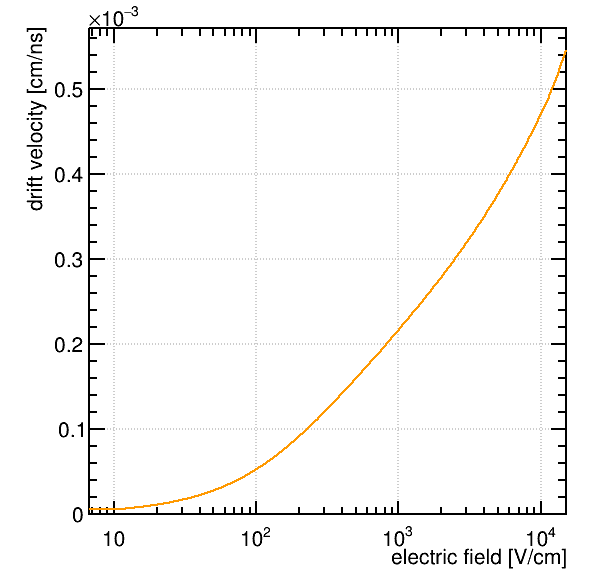

In [8]:
view = r.Garfield.ViewMedium()
view.SetMedium(lar)
ce = r.TCanvas()
view.SetCanvas(ce)
view.PlotElectronVelocity('e')
ce.Draw()

## Import an Elmer-created volume

In [9]:
elm=r.Garfield.ComponentElmer("9x9pixel_43um_31cm_response_v2b/mesh.header","9x9pixel_43um_31cm_response_v2b/mesh.elements","9x9pixel_43um_31cm_response_v2b/mesh.nodes",
    "dielectrics.dat","9x9pixel_43um_31cm_response_v2b/9x9pixel_43um_31cm_response_v2b.result","cm")

ComponentElmer::Initialise:
    Read 3175415 nodes and 2332783 elements from file 9x9pixel_43um_31cm_response_v2b/mesh.header.
    Read potentials from file 9x9pixel_43um_31cm_response_v2b/9x9pixel_43um_31cm_response_v2b.result.
    Set material 0 of 83 to eps 1e+10.
    Set material 1 of 83 to eps 1e+10.
    Set material 2 of 83 to eps 1e+10.
    Set material 3 of 83 to eps 1e+10.
    Set material 4 of 83 to eps 1e+10.
    Set material 5 of 83 to eps 1e+10.
    Set material 6 of 83 to eps 1e+10.
    Set material 7 of 83 to eps 1e+10.
    Set material 8 of 83 to eps 1e+10.
    Set material 9 of 83 to eps 1e+10.
    Set material 10 of 83 to eps 1e+10.
    Set material 11 of 83 to eps 1e+10.
    Set material 12 of 83 to eps 1e+10.
    Set material 13 of 83 to eps 1e+10.
    Set material 14 of 83 to eps 1e+10.
    Set material 15 of 83 to eps 1e+10.
    Set material 16 of 83 to eps 1e+10.
    Set material 17 of 83 to eps 1e+10.
    Set material 18 of 83 to eps 1e+10.
    Set material 19 o

In [10]:
elm.SetMedium(81,lar)
elm.SetWeightingField("9x9pixel_43um_31cm_response_v2b/9x9pixel_43um_31cm_response_v2b_weight.result","readout")

True

ComponentElmer::SetWeightingField:
    Loading field map for electrode readout.
    Read potentials from file 9x9pixel_43um_31cm_response_v2b/9x9pixel_43um_31cm_response_v2b_weight.result.


## Set up a sensor object

In [11]:
sensor=r.Garfield.Sensor()
sensor.AddComponent(elm)
sensor.SetArea(-ext_x,-ext_y,-ext_z,ext_x,ext_y,ext_z)
sensor.AddElectrode(elm,"readout")

Sensor::AddElectrode:
    Added readout electrode "readout".
    All signals are reset.


## Set up the object for field visualization

## View Electric Potential 

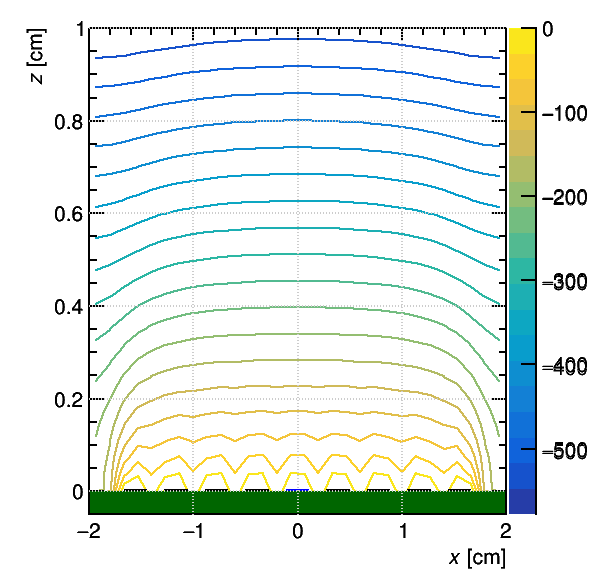

In [12]:
c1 = r.TCanvas();
vf = r.Garfield.ViewField();
vf.SetSensor(sensor);
vf.SetCanvas(c1);
# Here I zoom in to see z <=1 cm
# Can show the field non-uniform in the near field around pixels
vf.SetArea(-ext_x,-0.05,ext_x,1); 
vf.SetNumberOfContours(20);
vf.SetNumberOfSamples2d(30,30);
vf.SetPlane(0,-1,0,0,0,0);
vf.PlotContour("v");
vFE =r.Garfield.ViewFEMesh();
vFE.SetCanvas(c1);
vFE.SetComponent(elm);
vFE.SetPlane(0,-1,0,0,0,0);
vFE.SetFillMesh(True);
vFE.SetColor(0,r.kBlue); # Readout Pixel
vFE.SetColor(82,r.kGreen+3);
vFE.SetArea(-ext_x,-ext_y,-ext_z,ext_x,ext_y,ext_z);
vf.PlotContour("v");
vFE.Plot(True)
c1.Draw();

## View Weighting Potential

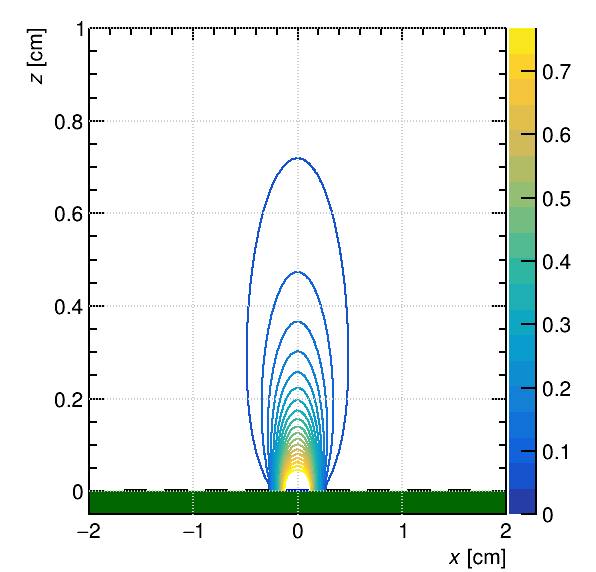

In [13]:
c2 = r.TCanvas();
vf_w = r.Garfield.ViewField();
vf_w.SetSensor(sensor);
vf_w.SetCanvas(c2);
# To see the weighting potential around the readout pixel
vf_w.SetArea(-ext_x,-0.05,ext_x,1); 
vf_w.SetNumberOfContours(20);
vf_w.SetNumberOfSamples2d(500,500);
vf_w.SetPlane(0,-1,0,0,0,0);
vf_w.PlotContourWeightingField("readout", "v");
vFE.SetCanvas(c2);
vFE.Plot(True);
c2.Draw();

## Generate induced current
### Create drift object

In [14]:
tmin=0
tmax = 200000
tstep=50
nTimeBins = int((tmax-tmin)/tstep)
sensor.SetTimeWindow(tmin,tstep,nTimeBins)
drift_length = 304.31/10 # [cm] drift length from larnd-sim yaml 

drifte = r.Garfield.AvalancheMC();
drifte.SetSensor(sensor)
drifte.DisableDiffusion()
drifte.DisableAttachment()
drifte.SetTimeSteps(tstep)

cD=r.TCanvas('cD','',600,600)
vFE =r.Garfield.ViewFEMesh();
vFE.SetCanvas(cD);
vFE.SetComponent(elm);
vFE.SetArea(-ext_x,-ext_y,-ext_z,ext_x,ext_y,ext_z)
vFE.SetPlane(0,-1,0,0,0,0);
vFE.SetFillMesh(True);
vFE.SetColor(0,r.kBlue);
vFE.SetColor(82,r.kGreen+3);

viewDrift = r.Garfield.ViewDrift()
viewDrift.SetArea(-ext_x,-ext_y,-0.05,ext_x,ext_y,1)
viewDrift.SetCanvas(cD);
viewDrift.SetPlane(0,-1,0,0,0,0);
drifte.EnablePlotting(viewDrift)

Sensor::SetTimeWindow: Resetting all signals.


### Drift a single electron

In [15]:
drifte.DriftElectron(0,0,drift_length,0)

True

### View drift path

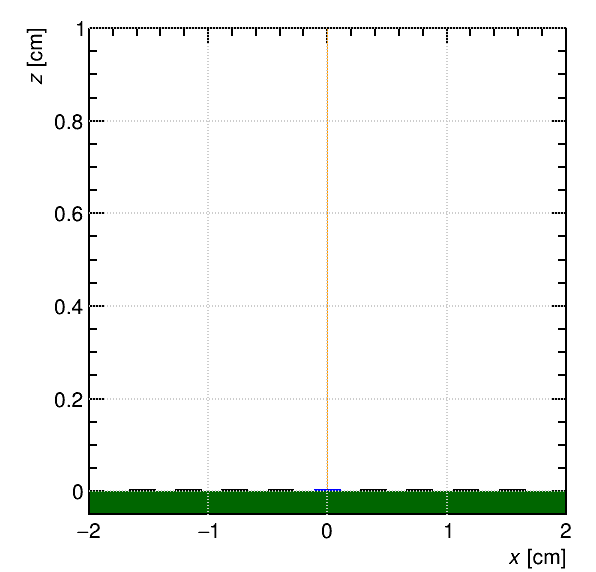

In [16]:
viewDrift.Plot(True)
vFE.Plot(True)
cD.Draw()

### Plot induced current

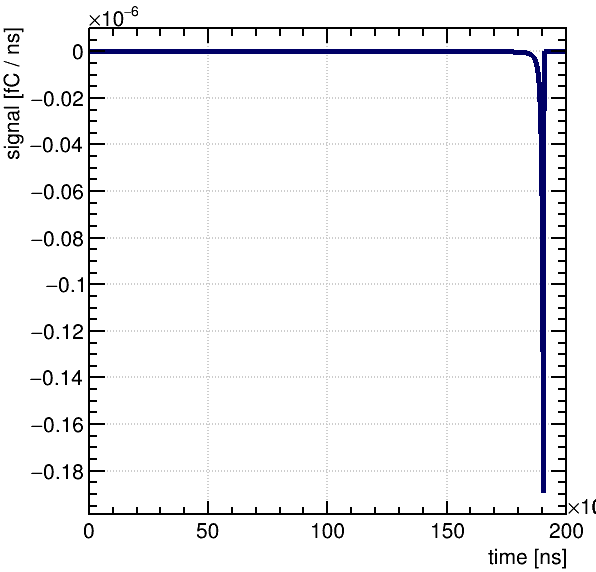

In [17]:
cSignal = r.TCanvas("signal","Signal")
vSignal = r.Garfield.ViewSignal()
vSignal.SetSensor(sensor)
vSignal.SetCanvas(cSignal)
vSignal.PlotSignal("readout")
cSignal.Draw()

### LArPix samples the integrated charge

In [18]:
induce_s=[]
induce_t = np.arange(tmin,tmax,tstep)
for j in range(nTimeBins):
    induce_s.append(sensor.GetSignal("readout",j))
induce_s = np.array(induce_s)
induce_c = induce_s*tstep*1e-15/(-1.60217733e-19)
integrated_c = np.cumsum(induce_c)

Text(0, 0.5, 'Integrated Charge [e-]')

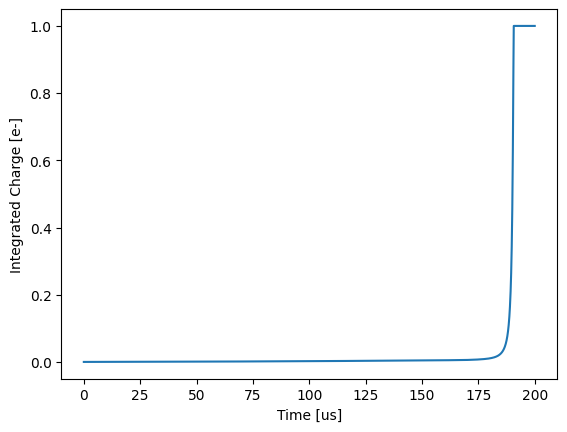

In [19]:
plt.plot(induce_t/1000,integrated_c)
plt.xlabel("Time [us]")
plt.ylabel("Integrated Charge [e-]")